In [ ]:
import torch
import torchvision
import clip

from pathlib import Path
from annoy import AnnoyIndex
from IPython.display import Image, display
from tqdm import tqdm

In [ ]:
# set torch 🔦 device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

# load CLIP 📎 model
model, preprocess = clip.load("ViT-B/32", device)
logit_scale = model.logit_scale.exp()
device

device(type='cuda')

In [ ]:
def collate_images_to_dict(path, preprocess, clear_cache=False):
    savefile = path/'memery.pt'
    if clear_cache == True and savefile.exists():
        savefile.unlink() # remove savefile if need be
        
    # load or generate the encodings 🗜️
    # currently this just checks to see if there's a savefile, not if anything has changed since save time
    if savefile.exists():
        save_dict = torch.load(savefile)
        image_names = [k for k in save_dict.keys()]
        image_features = torch.stack([v for v in save_dict.values()]).to(device)
        
    else:
        image_features = torch.tensor(()).to(device)
        with torch.no_grad():
            imagefiles=torchvision.datasets.ImageFolder(root=path, transform=preprocess)
            img_loader=torch.utils.data.DataLoader(imagefiles, batch_size=128, shuffle=False, num_workers=4)
            for images, labels in tqdm(img_loader):
                batch_features = model.encode_image(images)
                image_features = torch.cat((image_features, batch_features)).to(device)

        image_names = [Path(f[0]) for f in imagefiles.imgs]
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        
        save_dict = {str(k):v for k, v in zip(image_names, image_features)}
        torch.save(save_dict, savefile)

    return(image_names, image_features)

In [ ]:
def collate_images_to_trees(path, preprocess, clear_cache=False):
    t = AnnoyIndex(512, 'angular')
    savefile = path/'memery.ann'
    namefile = path/'names.txt'
    
    if clear_cache == True and savefile.exists():
        savefile.unlink()
        
    if savefile.exists():
        t.load(str(savefile))
        with open(str(namefile), 'r') as f:
            names =  [Path(o[:-1]) for o in f.readlines()]
    else:
        image_features = torch.tensor(()).to(device)
        with torch.no_grad():
            imagefiles=torchvision.datasets.ImageFolder(root=path, transform=preprocess)
            img_loader=torch.utils.data.DataLoader(imagefiles, batch_size=128, shuffle=False, num_workers=4)
            for images, labels in tqdm(img_loader):
                batch_features = model.encode_image(images)
                image_features = torch.cat((image_features, batch_features)).to(device)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        names = [Path(f[0]) for f in imagefiles.imgs]

        print("building trees...")
        for i, img in enumerate(image_features):
            t.add_item(i, img)

        t.build(10)

        # Save annoy index and list of filenames
        t.save(str(savefile))    
        with open(str(namefile), 'w') as f:
            f.writelines([f'{str(o)}\n' for o in names])
    
    return(names, t)

---

In [ ]:
def predict_from_text_dict(image_names, image_features, query):
    with torch.no_grad():
        text = clip.tokenize(query).to(device)
        text_features = model.encode_text(text)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        # matrix-vector product as logits
        logits_per_image = logit_scale * image_features @ text_features.float().t()
        
    scores = {image_names[i]: logit for i, logit in enumerate(logits_per_image)}
    top_scores = sorted(scores.items(), key=lambda item: item[1], reverse=True)
    return(top_scores)

In [ ]:
def predict_from_text_trees(names, treemap, query):
    with torch.no_grad():
        text = clip.tokenize(query).to(device)
        text_features = model.encode_text(text)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
    
    nn_indexes = t.get_nns_by_vector(text_features.t(), t.get_n_items())
    return(nn_indexes)

In [ ]:
def printi(images, n = 3, w = 200, start_index = 0):
    for im in images[start_index:start_index + n]:
#         print(f'{im}')
        try:
            display(Image(filename=im, width=w))
        except Exception as e:
            print(e)
# printi(image_names, 1)

In [ ]:
path = Path('/home/mage/Pictures/occult-imagery/')


In [ ]:
i_names, i_features = collate_images_to_dict(path, preprocess, clear_cache=False)

In [ ]:
names, t = collate_images_to_trees(path, preprocess, clear_cache=False)

---

/home/mage/Pictures/occult-imagery/www.sacred-texts.com/nam/sw/yml/img/12700.jpg


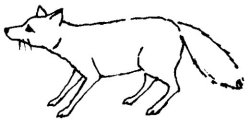

In [ ]:
results = predict_from_text_dict(i_names, i_features, query)

printi([file for file, score in results], 1, 100)

In [ ]:
print("number of images to search:",len(names))

number of images to search: 26762


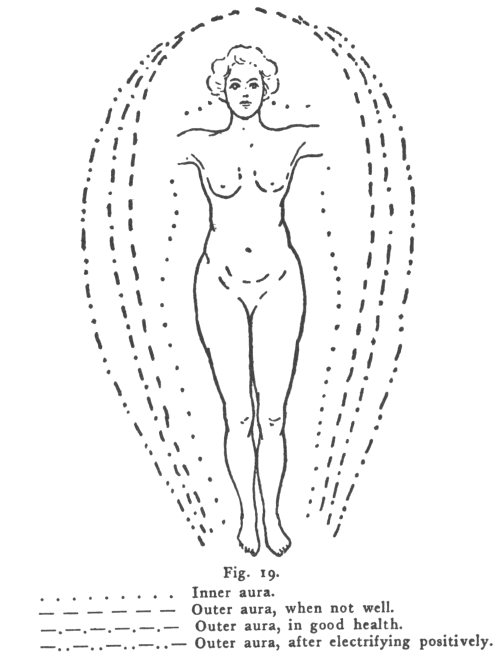

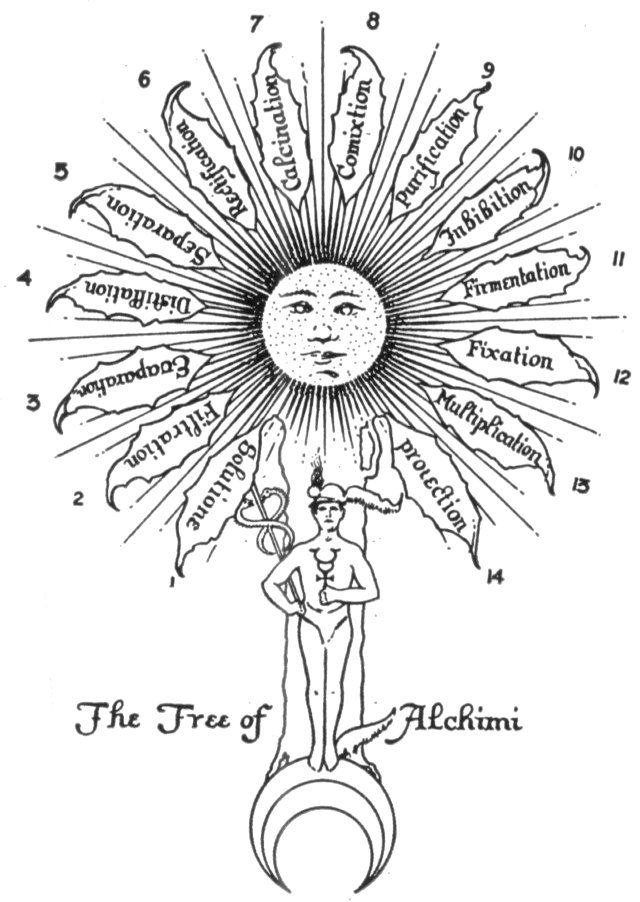

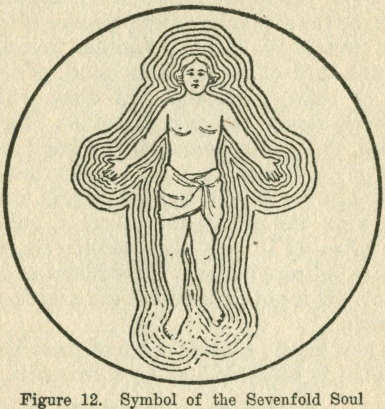

In [ ]:
query = "the human aura"
nn_indexes = predict_from_text_trees(names, t, query)

printi([str(names[i]) for i in nn_indexes], 3, 150)